# Quantitative Multi-Asset Allocation Framework
**Project: Implementation of a Momentum-Based Sector Rotation Strategy**
\
*Author: Jan Schefter* | *Date: November 2025*

## Executive Summary
In this project, a quantitative framework was developed to simulate systematic trading strategies based on historical data (backtesting). A **momentum strategy** within the US sector universe was examined. The goal was to test whether a rule-based rotation into the top 3 sectors (based on 6-month performance) achieves outperformance compared to a passive "Buy & Hold" strategy.


The framework covers the entire process:

1. **Data Ingestion:** Automated download of adjusted price data (Total Return).
2. **Signal Generation:** Algorithmic selection of assets.
3. **Backtesting:** Simulation of the equity curve.
4. **Risk Analysis:** Calculation of drawdowns.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

In [2]:
tickers = ["XLK", "XLV", "XLF", "XLY", "XLP", "XLE", "XLI", "XLU", "GLD", "BIL"]

## 1. Data & Universe
The investment universe consists of the **Sector SPDR ETFs** of the S&P 500, as well as Gold ("GLD") and short-term government bonds ("BIL") as a cash proxy. The observation period extends from **2010 to the present (Nov 18, 2025)** to cover various market phases (Bull Run, Corona Crash, Inflation Phase 2022).

In [3]:
raw_data = yf.download(
    tickers, 
    start="2010-01-01", 
    end="2025-11-18", 
    auto_adjust=False, 
    progress=False
)

In [4]:
df_prices = raw_data["Adj Close"]

In [5]:
df_prices = df_prices.dropna()

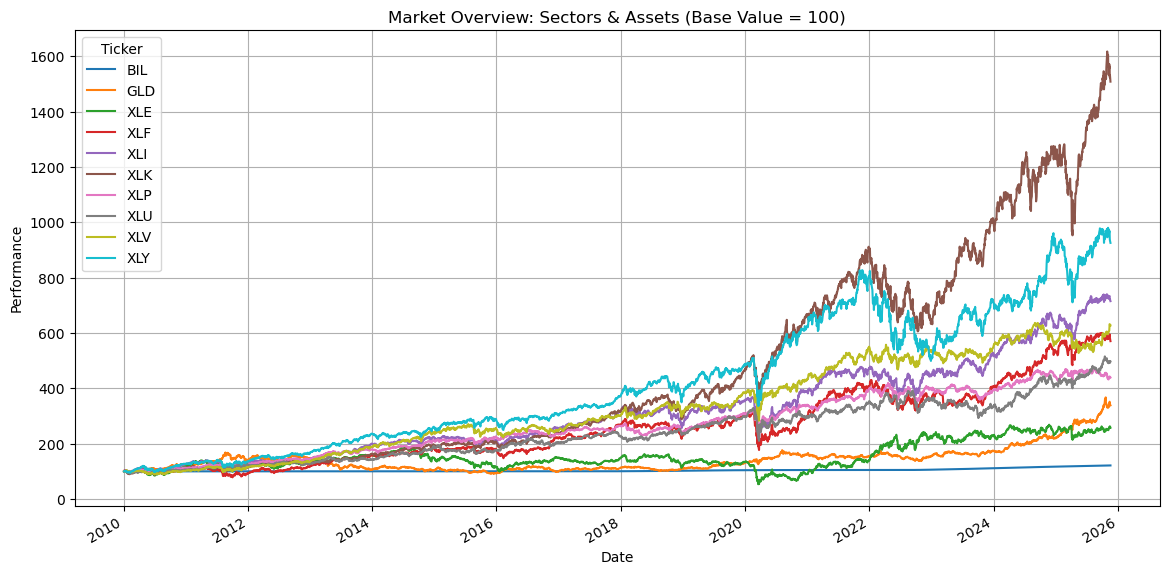

In [6]:
(df_prices / df_prices.iloc[0] * 100).plot(figsize=(14, 7))
plt.title("Market Overview: Sectors & Assets (Base Value = 100)")
plt.ylabel("Performance")
plt.grid(True)
plt.show()

## 2. Methodology: Cross-Sectional Momentum
The strategy is based on the scientifically grounded "Momentum Effect" (cf. Jegadeesh & Titman, 1993).

**The Rules:**
* **Lookback:** 126 trading days (approx. 6 months)
* **Selection:** Long position in the **Top 3 assets** with the highest relative strength
* **Weighting:** Equal Weight (1/3 per asset)
* **Rebalancing:** Monthly

In [7]:
momentum = df_prices.pct_change(126)

In [8]:
monthly_momentum = momentum.resample("ME").last() 

In [9]:
ranks = monthly_momentum.rank(axis=1, ascending=False)

In [10]:
top_3_mask = ranks <= 3

In [11]:
signals = top_3_mask.astype(float) 

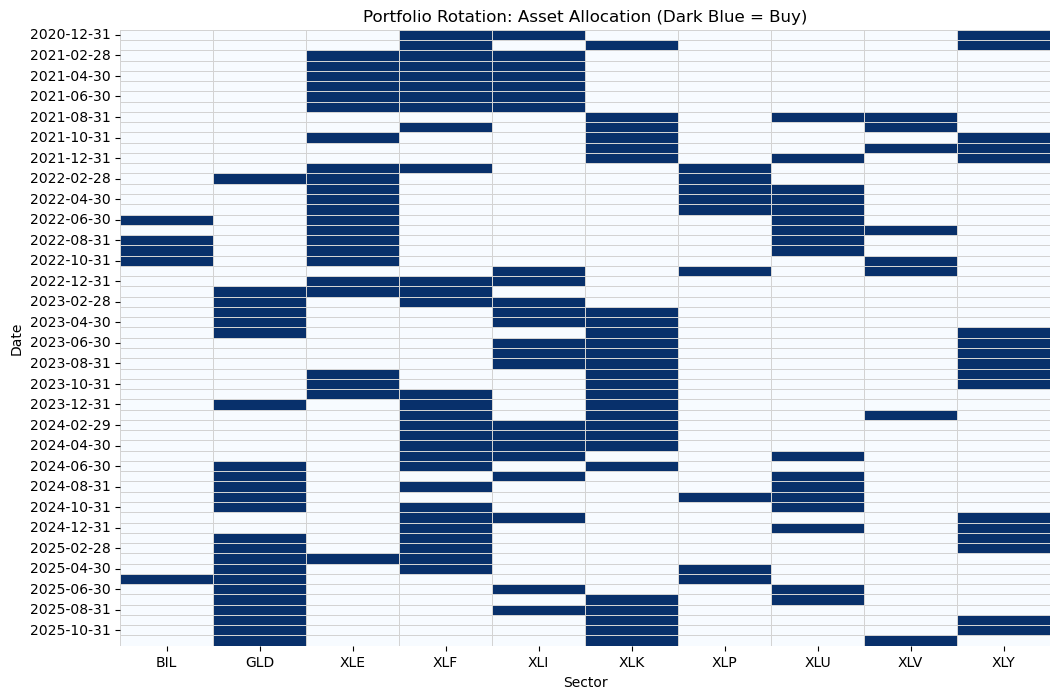

In [12]:
plt.figure(figsize=(12, 8))
plot_data = signals.tail(60).copy()
plot_data.index = plot_data.index.strftime('%Y-%m-%d')
sns.heatmap(
    plot_data,
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="lightgrey"
)

plt.title("Portfolio Rotation: Asset Allocation \
(Dark Blue = Buy)")
plt.ylabel("Date")
plt.xlabel("Sector")
plt.show()

In [13]:
daily_returns = df_prices.pct_change()

In [14]:
daily_signals = signals.reindex(daily_returns.index).ffill()

In [15]:
daily_signals = daily_signals.shift(1)

In [16]:
strategy_returns = (daily_signals * daily_returns).sum(axis=1) / 3

In [17]:
benchmark_returns = daily_returns.mean(axis=1)

In [18]:
start_capital = 10000

In [19]:
strategy_equity = start_capital * (1 + strategy_returns).cumprod()
benchmark_equity = start_capital * (1 + benchmark_returns).cumprod()

## 3. Backtest Results & Risk Analysis
The following plot compares the performance of the Momentum Strategy (Green) with an equal-weighted Benchmark Portfolio (Grey). Furthermore, the **Maximum Drawdown** (loss risk in crises) is calculated subsequently.

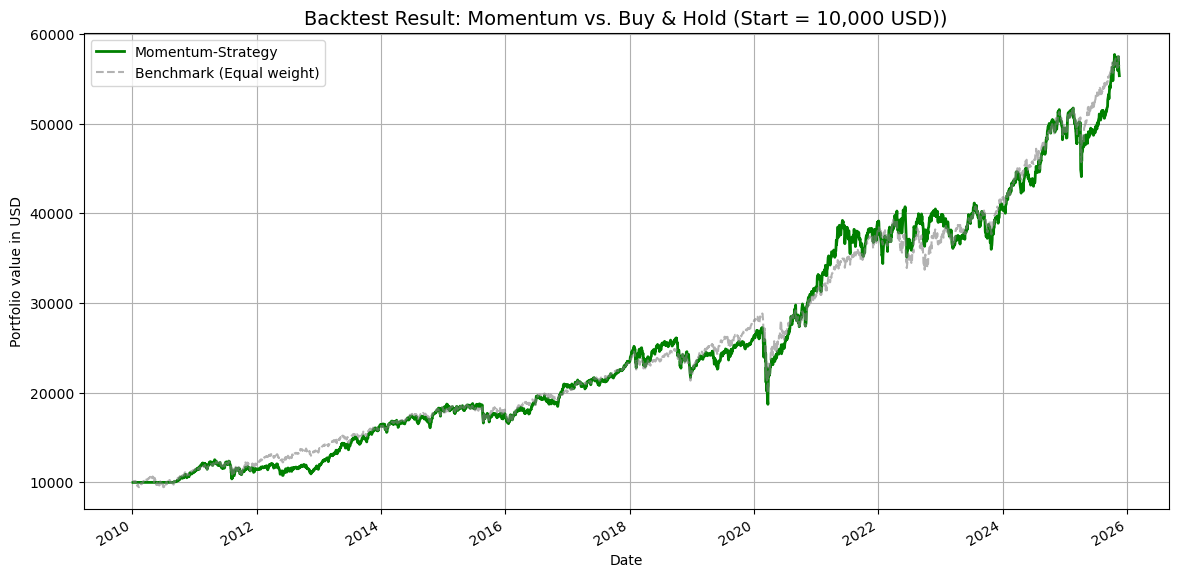

In [20]:
plt.figure(figsize=(14, 7))
strategy_equity.plot(
    label="Momentum-Strategy", 
    color="green", 
    linewidth=2
)
benchmark_equity.plot(
    label="Benchmark (Equal weight)", 
    color="grey", 
    alpha=0.6, 
    linestyle="--"
)

plt.title("Backtest Result: \
Momentum vs. Buy & Hold (Start = 10,000 USD))", fontsize=14)
plt.ylabel("Portfolio value in USD")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
print(f"Final Balance Strategy: {strategy_equity.iloc[-1]:.2f} USD")
print(f"Final Balance Benchmark: {benchmark_equity.iloc[-1]:.2f} USD")

Final Balance Strategy: 55352.30 USD
Final Balance Benchmark: 56401.63 USD


In [22]:
def calculate_drawdown(equity_curve):
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    return drawdown

In [23]:
strategy_dd = calculate_drawdown(strategy_equity)
benchmark_dd = calculate_drawdown(benchmark_equity)

In [24]:
max_dd_strategy = strategy_dd.min()
max_dd_benchmark = benchmark_dd.min()

In [25]:
print(f"Max Drawdown Strategy: {max_dd_strategy:.2%}")
print(f"Max Drawdown Benchmark: {max_dd_benchmark:.2%}")

Max Drawdown Strategy: -31.38%
Max Drawdown Benchmark: -30.74%


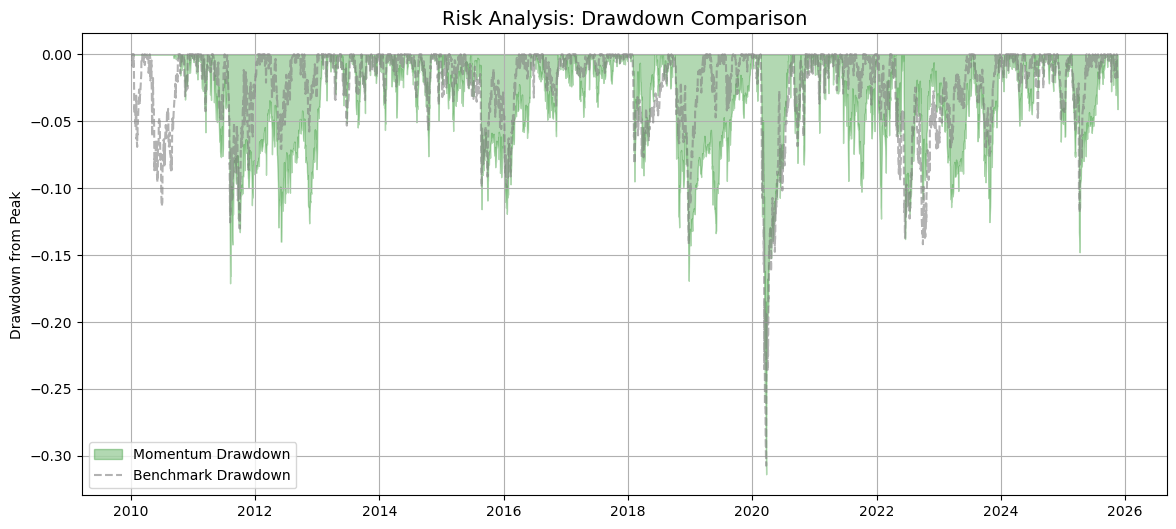

In [26]:
plt.figure(figsize=(14, 6))
plt.fill_between(
    strategy_dd.index, 
    strategy_dd, 
    0, 
    color="green", 
    alpha=0.3, 
    label="Momentum Drawdown"
)
plt.plot(
    benchmark_dd, 
    color="grey", 
    alpha=0.6, 
    linestyle="--", 
    label="Benchmark Drawdown"
)

plt.title("Risk Analysis: Drawdown Comparison", fontsize=14)
plt.ylabel("Drawdown from Peak")
plt.legend()
plt.grid(True)
plt.show()

## 4. Conclusion & Outlook

### Analysis of Results 
The backtest over the period 2010–2025 shows that a pure **Sector-Momentum-Strategy** ("Long-Only") correlates strongly with the overall market.
* **Bull Markets:** In phases of stable trends (e.g., 2014-2015, 2017, 2021), the strategy manages to keep up with or slightly outperform the benchmark by overweighting winning sectors (mostly Tech & Consumer Discretionary).
* **Crises:** In systemic market phases (e.g., Corona Crash 2020), diversification across sectors offers no protection, as correlations tend toward 1. The strategy records almost identical drawdowns as the market here.

### Model Limitations
* **Lag (Inertia):** The chosen 6-month indicator (126 days) is robust against "noise" but reacts too slowly to abrupt trend changes ("V-Shape" recoveries like in March 2020). This led to a delayed reentry after the crash.
* **Long-Only Bias:** Since the strategy is always 100% invested, there is no protection mechanism against bear markets (like 2022) where almost all asset classes fall.
* **Transaction Costs:** These were neglected in the simulation. Due to monthly rebalancing, real transaction fees and tax effects would slightly reduce the net return.

### Outlook (Next Steps) 
To improve the risk-return profile, the following extensions of the framework would be the next logical step:
* **Market Regime Filter:** Implementation of "Absolute Momentum" (e.g. SMA 200 on the S&P 500). If the market falls below the trend, the portfolio shifts into cash or government bonds (BIL).
* **Volatility Scaling:** Instead of equal weighting (Equal Weight), positions could be weighted based on their inverse volatility (Risk Parity) to automatically reduce risk in turbulent market phases.